In [22]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy as sp

# Load Calibration data

In [23]:
data = pd.read_csv("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/data/dynamic/calibration_incidence.csv", sep=',',decimal='.')
data=data.drop("Unnamed: 0",axis=1)
data.head(23)


,year,var,Lower,Mean,Upper
0,2000,e_inc_num,56000,139000,259000
1,2001,e_inc_num,57000,159000,312000
2,2002,e_inc_num,57000,175000,357000
3,2003,e_inc_num,54000,206000,456000
4,2004,e_inc_num,54000,221000,501000
5,2005,e_inc_num,56000,226000,510000
6,2006,e_inc_num,56000,239000,549000
7,2007,e_inc_num,60000,235000,525000
8,2008,e_inc_num,66000,221000,467000
9,2009,e_inc_num,68000,228000,483000


Text(0.5, 1.0, 'Estimated Incident cases of TB')

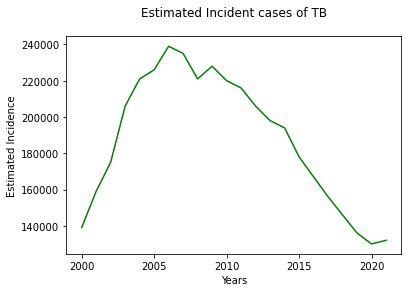

In [24]:
plt.plot(data["year"], data['Mean'],label="mean_estimate",color="green")
plt.xlabel('Years')
plt.ylabel('Estimated Incidence')
plt.title("Estimated Incident cases of TB",pad=20)

# Load Model

In [25]:
model = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V13_years.mdl")

In [26]:
model_output = model.run()


<AxesSubplot:>

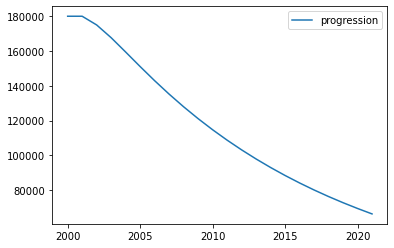

In [27]:
model_output.plot(y="progression")

## Calibration

In [28]:
#Set up observable and claibration parameters
observable = "progression"
parameter1 = 'transmission rate'
parameter2 = 'relapse rate'
parameter3 = 'initial incident'
parameter4="progression rate"
parameter5 = 'initial latent'
parameter6 = 'progression time'




def error(param_list):
    #unpack the parameter list
    parameter1_value,parameter2_value,parameter3_value,parameter4_value,parameter5_value,parameter6_value = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'transmission rate':parameter1_value,
                               'relapse rate':parameter2_value,
                               'initial incident': parameter3_value,
                               "progression rate":parameter4_value,
                               'initial latent': parameter5_value,
                               'progression time': parameter6_value
                              },
                       return_columns=['progression'])
    #print(result['progression'] -data['Mean'])
    
    result=result.reset_index(drop=True)
    #print(result)
    calDat=data.reset_index(drop=True)
    calDat=calDat["Mean"]
    
    error=sum((result['progression'] - calDat)**2)
    #print(error)
    #return the sum of the squared errors
    return  error

In [29]:
parameter1_guess = 0.05
parameter1_bounds = (0.0, 1)

parameter2_guess = 0.1
parameter2_bounds = (0.004, 0.1)

parameter3_guess = 100000
parameter3_bounds = (1, 3000000)

parameter4_guess = 0.08
parameter4_bounds = (0, 0.2)


parameter5_guess = 100000
parameter5_bounds = (1, 3000000)

parameter6_guess = 2
parameter6_bounds = (1,5)



res = sp.optimize.minimize(error,
                           x0=[parameter1_guess,parameter2_guess,parameter3_guess,parameter4_guess,parameter5_guess,parameter6_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds,parameter2_bounds,parameter3_bounds,parameter4_bounds,parameter5_bounds,parameter6_bounds])
res

      fun: 823510209.12376
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.03380585e+06,  1.72981470e+10, -2.14325581e+02, -9.05442238e+06,
        5.12000000e+02, -2.80356409e+05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1043
      nit: 84
     njev: 149
   status: 0
  success: True
        x: array([3.68338262e-01, 4.00000000e-03, 1.97100925e+06, 1.55857374e-01,
       9.88380716e+05, 3.96606523e+00])

In [30]:
p1, p2, p3,p4,p5,p6= res.x
result = model.run(params=
                   {
                       'transmission rate':p1,
                               'relapse rate':p2,
                               'initial incident': p3,
                               "progression rate":p4,
                       'initial latent': p5,
                       'progression time': p6
                   },
                   return_columns=['progression'])

result

,progression
2000,154046.422534
2001,154046.422534
2002,173828.793546
2003,196870.101397
2004,216050.700409
2005,229037.504003
2006,235790.337349
2007,237230.359408
2008,234557.065150
2009,228924.621517


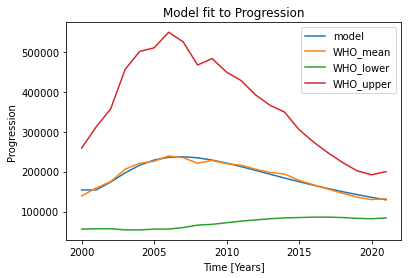

In [31]:
plt.plot(result.index, result['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)

## Explore Calibrated

In [32]:
model_cal = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V13_years_cal.mdl")

In [33]:
model_cal_output = model_cal.run()
display(model_cal_output)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Total TB deaths,Susceptible,initial detected,Detected and Treated TB,Detection,Cumulative Cases,...,deaths T,total pop,general mortality,infection,initial incident,initial latent,Latent TB infection,relapse rate,transmission rate,progression rate
2000,2021,2000,1,1,0.000000,3.482561e+07,215000,2.150000e+05,906664.600000,0.000000e+00,...,1720.000000,3.800000e+07,0.008,665281.841318,1971010.0,988381,9.883810e+05,0.004,0.3683,0.156
2001,2021,2000,1,1,73912.875000,3.494572e+07,215000,1.119085e+06,519667.465260,1.541874e+05,...,8952.676800,3.868609e+07,0.008,375844.873384,1971010.0,988381,1.491568e+06,0.004,0.3683,0.156
2002,2021,2000,1,1,116277.070537,3.537352e+07,215000,1.625323e+06,329960.897795,3.083749e+05,...,13002.584400,3.941744e+07,0.008,237080.700039,1971010.0,988381,1.701293e+06,0.004,0.3683,0.156
2003,2021,2000,1,1,143176.056771,3.595714e+07,215000,1.935780e+06,248730.454661,4.878840e+05,...,15486.240570,4.017889e+07,0.008,178221.472584,1971010.0,988381,1.745254e+06,0.004,0.3683,0.156
2004,2021,2000,1,1,163452.996009,3.661627e+07,215000,2.161281e+06,221878.598604,6.951004e+05,...,17290.249320,4.096220e+07,0.008,158799.891609,1971010.0,988381,1.702297e+06,0.004,0.3683,0.156
2005,2021,2000,1,1,181540.925243,3.731148e+07,215000,2.357224e+06,218666.861025,9.232985e+05,...,18857.795117,4.176335e+07,0.008,156413.426877,1971010.0,988381,1.619281e+06,0.004,0.3683,0.156
2006,2021,2000,1,1,199367.028044,3.802595e+07,215000,2.547605e+06,222982.976720,1.163548e+06,...,20380.836464,4.258079e+07,0.008,159434.370958,1971010.0,988381,1.522490e+06,0.004,0.3683,0.156
2007,2021,2000,1,1,217544.988103,3.875457e+07,215000,2.740016e+06,227301.361629,1.407785e+06,...,21920.130240,4.341423e+07,0.008,162456.377961,1971010.0,988381,1.425508e+06,0.004,0.3683,0.156
2008,2021,2000,1,1,236074.990410,3.949768e+07,215000,2.934437e+06,228792.521842,1.649851e+06,...,23475.499571,4.426398e+07,0.008,163458.219955,1971010.0,988381,1.334495e+06,0.004,0.3683,0.156
2009,2021,2000,1,1,254104.835881,4.025763e+07,215000,3.128017e+06,227252.372875,1.885566e+06,...,25024.133750,4.513123e+07,0.008,162301.785810,1971010.0,988381,1.251561e+06,0.004,0.3683,0.156


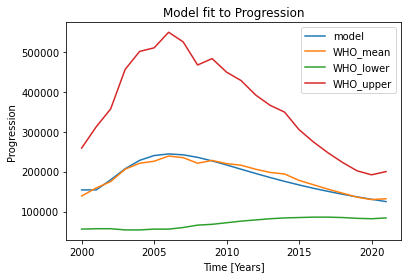

In [34]:
plt.plot(model_cal_output.index, model_cal_output['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)